In [1]:
import os,json
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')

In [2]:
WRF_FOLDER = 'M02_EnergyPlus_Forcing_Historical'

In [3]:
wrf_headers = ['PSFC', 'Q2', 'T2', 'RH', 'WINDS', 'GLW', 'SWDOWN']
heat_year = 2018
heat_month = 7
heat_day_start = 2
heat_num_days = 16
row = 384
col = 339

In [4]:
INPUT_FOLDER = 'meta'
INPUT_FILE_NAME = 'wrf-grids-origin.geojson'
county_domain = dict()
with open(os.path.join(WRF_FOLDER, INPUT_FOLDER, INPUT_FILE_NAME), 'r') as f:
    data = json.load(f)
    for grid in data['features']:
        county_domain[grid['properties']['id']] = grid['properties']['domain_flag']
len(county_domain)

130176

In [5]:
wrf_id_set = set()
with open(os.path.join(WRF_FOLDER, INPUT_FOLDER, INPUT_FILE_NAME), 'r') as f:
    data = json.load(f)
    for grid in data['features']:
        if grid['properties']['domain_flag'] > 0:
            wrf_id_set.add(grid['properties']['id'])

## Plotting WRF grid data

In [6]:
heat_month = 7
heat_day_start = 2
heat_num_days = 16
wrf_header = 'T2'
result_folder = 'T2'
wrf_data = dict()
year = str(heat_year)
month = str(heat_month).zfill(2)

# If plotting results data, change folder, header name and delimiter
# wrf_header = 'HEATI_M0'
# result_folder = 'eplus-grid-emission-results'

for day in range(heat_day_start, heat_day_start + heat_num_days):
    d = day - heat_day_start
    for h in range(24):
        wrf_data[d * 24 + h] = np.zeros((row, col))
        date = str(day).zfill(2)
        hour = str(h).zfill(2)
        day = str(day).zfill(2)
#         file_name = os.path.join(WRF_FOLDER, result_folder, 'Variable_' + wrf_header + '_' + year + month + date + hour + '.txt')
        
        file_name = os.path.join(WRF_FOLDER, wrf_header, 'Variable_' + wrf_header + '_' + year + month + date + hour + '.txt')
        with open(file_name, 'r') as f:
            for i in range(row):
#                 cur_wrf_data = f.readline().strip().split(',')
                cur_wrf_data = f.readline().strip().split('	') 
                for j in range(col):
                    if county_domain[i * col + j] > 0 and float(cur_wrf_data[j]) > 0:
                        wrf_data[d * 24 + h][i, j] = float(cur_wrf_data[j])
                    else:
                        wrf_data[d * 24 + h][i, j] = None

In [7]:
df_wrf_data = pd.DataFrame()
for data in wrf_data:
    df_wrf_data[data] = wrf_data[data].flatten()

df_wrf_data_non_zero = dict()
for data in df_wrf_data:
    df_wrf_data_non_zero[data] = list()   
    for i in range(len(df_wrf_data[data])):
        if i in wrf_id_set:
            df_wrf_data_non_zero[data].append(float(df_wrf_data[data][i]))

In [8]:
df_wrf_data_plot = pd.DataFrame(df_wrf_data_non_zero)
df_v = pd.DataFrame()
df_v['mean']  = df_wrf_data_plot.mean(axis = 0)
df_v['95 Percentile'] = df_wrf_data_plot.quantile(.95)
df_v['5 Percentile'] = df_wrf_data_plot.quantile(.05)

In [9]:
df_v['mean'].head(24)

0     24.755189
1     23.908948
2     22.623309
3     19.720477
4     18.426402
5     17.818800
6     17.297373
7     16.653622
8     16.024219
9     15.455103
10    15.106981
11    14.760015
12    14.436543
13    14.360918
14    17.663272
15    19.715056
16    21.105475
17    22.197290
18    23.257526
19    24.165497
20    24.819427
21    25.191400
22    25.175683
23    24.799615
Name: mean, dtype: float64

In [10]:
df_wrf_data_plot.describe()

,0,1,2,3,4,5,6,7,8,9,...,374,375,376,377,378,379,380,381,382,383
count,37770.000000,37770.000000,37770.000000,37770.000000,37770.000000,37770.000000,37770.000000,37770.000000,37770.000000,37770.000000,...,37770.000000,37770.000000,37770.000000,37770.000000,37770.000000,37770.000000,37770.000000,37770.000000,37770.000000,37770.000000
mean,24.755189,23.908948,22.623309,19.720477,18.426402,17.818800,17.297373,16.653622,16.024219,15.455103,...,20.882410,22.968635,24.660180,26.278725,27.555157,28.680273,29.396174,29.597432,29.278194,28.766414
std,3.217834,3.008920,2.731460,2.397543,2.552566,2.573667,2.709874,2.803061,2.801088,2.772234,...,2.496659,2.898032,3.200221,3.610255,3.671763,3.728883,3.860970,3.894446,3.805414,3.612093
min,16.951000,17.261000,17.464000,15.273000,12.814000,10.701000,9.718400,9.201300,9.229300,8.808300,...,17.081000,18.161000,18.303000,18.112000,17.987000,18.002000,18.205000,18.327000,18.371000,18.460000
25%,23.050000,22.471000,21.404000,18.422000,17.671000,16.604000,15.415000,15.181000,14.607000,14.022000,...,18.824000,20.453000,22.261000,24.251000,26.010000,27.385000,27.857000,27.539000,27.370000,27.052000
50%,24.557000,23.743000,22.328000,19.211000,18.397000,18.030000,17.960000,17.196000,16.684000,15.915000,...,21.108000,22.030000,23.702000,25.212000,27.150000,28.699000,29.385000,29.533000,29.184000,28.708000
75%,26.002000,24.826000,23.292000,21.086000,19.352000,18.790000,18.264000,17.702000,17.138000,16.725000,...,22.630000,25.639000,27.651000,28.216000,28.383000,29.776000,30.840000,31.670000,30.962000,30.320000
max,33.913000,33.080000,31.361000,26.493000,24.422000,23.462000,22.741000,21.993000,21.332000,20.868000,...,26.557000,28.766000,31.351000,35.389000,36.538000,37.591000,38.505000,38.777000,38.462000,37.731000


No handles with labels found to put in legend.


Text(0, 0.5, 'Hourly Temperature (°C)')

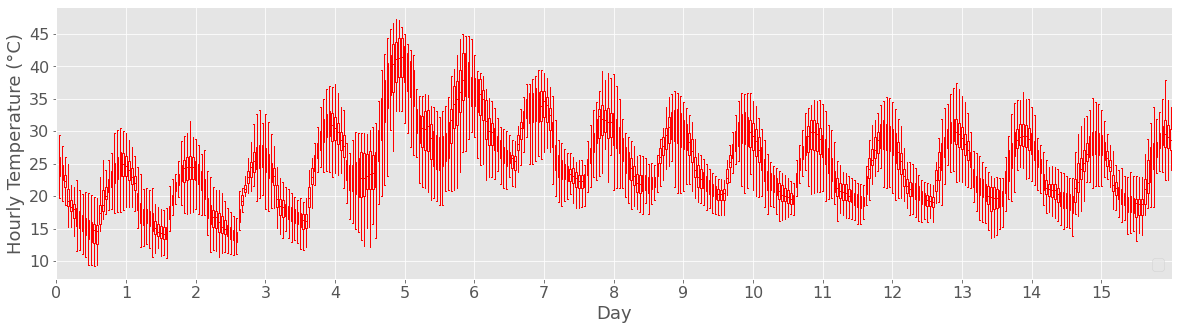

In [15]:
heat_day_start = 0
heat_num_days = 16
plt.figure(figsize=(20,5))
ax = df_wrf_data_plot.plot(ax = plt.gca(), color = 'r', kind='box', showfliers=False)
plt.xticks(np.arange(24*heat_day_start, 24*(heat_num_days + heat_day_start), 24), np.arange(heat_day_start, heat_num_days + heat_day_start), fontsize=16)
plt.yticks(fontsize=16)
ax.set_xlabel('Day', fontsize=18)
plt.legend(loc='lower right', prop={'size': 16})
ax.set_ylabel('Hourly Temperature (°C)', fontsize=18)

# ax.set_ylabel('Hourly Heat Flux (W/m2)', fontsize=18)
# ax.set_ylabel('Hourly Relative Humidity (%)', fontsize=18)
# ax.set_ylabel('Hourly Wind Speed (m/s)', fontsize=18)

Text(0, 0.5, 'Hourly Temperature (°C)')

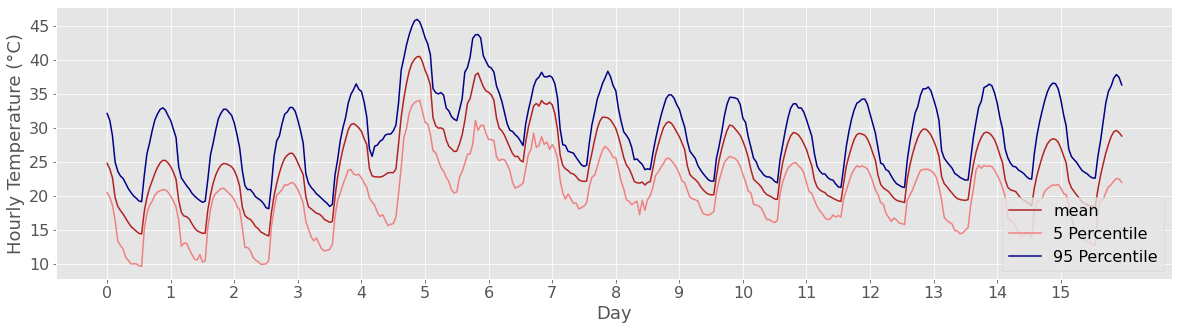

In [16]:
heat_day_start = 0
heat_num_days = 16
plt.figure(figsize=(20,5))
ax = df_v['mean'].plot(ax = plt.gca(), color = '#B22222')
ax1 = df_v['5 Percentile'].plot(ax = plt.gca(), color = '#F08080')
ax2 = df_v['95 Percentile'].plot(ax = plt.gca(), color = '#000088')
plt.xticks(np.arange(24*heat_day_start, 24*(heat_num_days + heat_day_start), 24), np.arange(heat_day_start, heat_num_days + heat_day_start), fontsize=16)
plt.yticks(fontsize=16)
ax.set_xlabel('Day', fontsize=18)
plt.legend(loc='lower right', prop={'size': 16})
ax.set_ylabel('Hourly Temperature (°C)', fontsize=18)

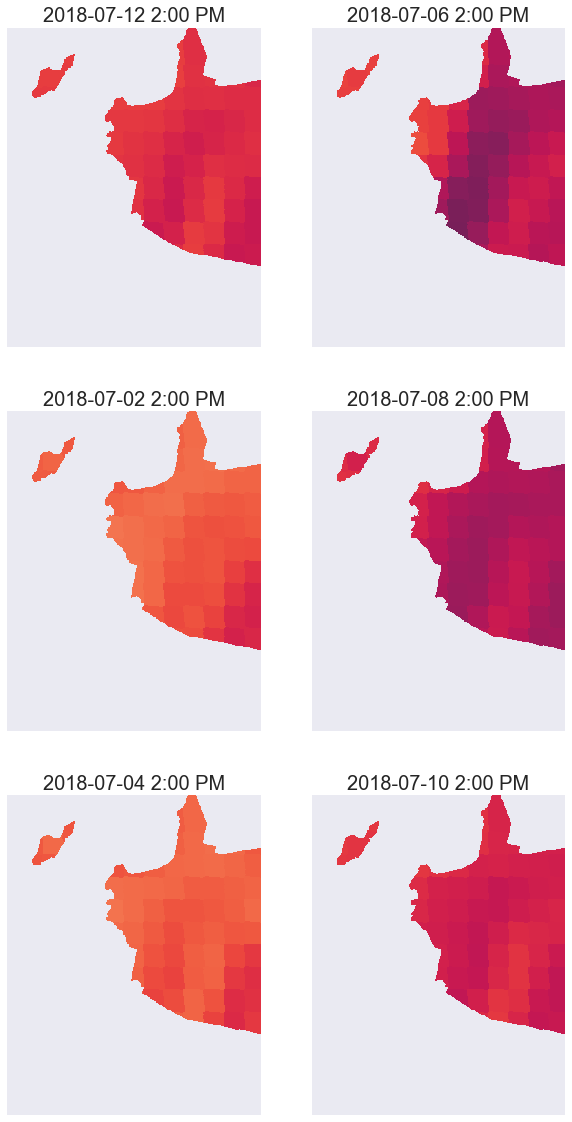

In [18]:
vmin = 0
vmax = 50
sns.set(font_scale=1.5)
f,((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(10, 20))

g1 = sns.heatmap(wrf_data[10 * 24 + 14], vmin=vmin, vmax=vmax, ax=ax1, cmap= sns.cm.rocket_r, cbar=False)
g1.set_title('2018-07-12 2:00 PM', fontsize=20)
g1.figure.axes[-1].yaxis.label.set_size(4)
g2 = sns.heatmap(wrf_data[4 * 24 + 14], vmin=vmin, vmax=vmax, ax=ax2, cmap= sns.cm.rocket_r, cbar=False)
g2.set_title('2018-07-06 2:00 PM', fontsize=20)
g3 = sns.heatmap(wrf_data[0 * 24 + 14], vmin=vmin, vmax=vmax, ax=ax3, cmap= sns.cm.rocket_r, cbar=False)
g3.set_title('2018-07-02 2:00 PM', fontsize=20)
g4 = sns.heatmap(wrf_data[6 * 24 + 14], vmin=vmin, vmax=vmax, ax=ax4, cmap= sns.cm.rocket_r, cbar=False)
g4.set_title('2018-07-08 2:00 PM', fontsize=20)
g5 = sns.heatmap(wrf_data[2 * 24 + 14], vmin=vmin, vmax=vmax, ax=ax5, cmap= sns.cm.rocket_r, cbar=False)
g5.set_title('2018-07-04 2:00 PM', fontsize=20)
g6 = sns.heatmap(wrf_data[8 * 24 + 14], vmin=vmin, vmax=vmax, ax=ax6, cmap= sns.cm.rocket_r, cbar=False)
g6.set_title('2018-07-10 2:00 PM', fontsize=20)

for g in [g1, g2, g3, g4, g5, g6]:
    g.set_xticks([])
    g.set_yticks([])
    g.set_ylabel('')
    g.set_xlabel('')
